In [1]:
# Imports

import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras import Model
import matplotlib.pyplot as plt
import seaborn as sns
import os
import requests

In [2]:
# tensorflow version

tf.__version__

'2.0.0'

In [3]:
current_path = os.path.abspath(os.curdir)
path="https://web.stanford.edu/class/archive/cs/cs109/cs109.1166/stuff/titanic.csv"

if not os.path.isdir(os.path.join(current_path, "data")):
    os.mkdir("data")
    os.chdir(os.path.join(current_path, "data"))
    open("titanic.csv", "wb").write(requests.get(path).content);

In [4]:
os.chdir(os.path.join(current_path, "data"))

data=pd.read_csv("titanic.csv", sep=',')
data.head(5)

,Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,0,3,Mr. Owen Harris Braund,male,22.0,1,0,7.2500
1,1,1,Mrs. John Bradley (Florence Briggs Thayer) Cum...,female,38.0,1,0,71.2833
2,1,3,Miss. Laina Heikkinen,female,26.0,0,0,7.9250
3,1,1,Mrs. Jacques Heath (Lily May Peel) Futrelle,female,35.0,1,0,53.1000
4,0,3,Mr. William Henry Allen,male,35.0,0,0,8.0500


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887 entries, 0 to 886
Data columns (total 8 columns):
Survived                   887 non-null int64
Pclass                     887 non-null int64
Name                       887 non-null object
Sex                        887 non-null object
Age                        887 non-null float64
Siblings/Spouses Aboard    887 non-null int64
Parents/Children Aboard    887 non-null int64
Fare                       887 non-null float64
dtypes: float64(2), int64(4), object(2)
memory usage: 55.6+ KB


In [6]:
data.shape

(887, 8)

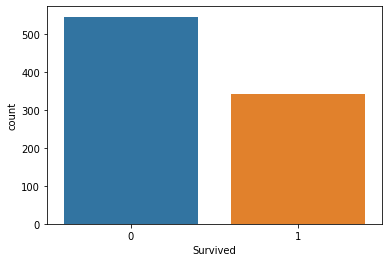

In [7]:
sns.countplot("Survived", data=data);

In [8]:
data.drop("Name", axis=1, inplace=True)

In [9]:
cat = [col for col in data.columns if data[col].dtype == 'object']
num = [col for col in data.columns if data[col].dtype != 'object']
cat, num

(['Sex'],
 ['Survived',
  'Pclass',
  'Age',
  'Siblings/Spouses Aboard',
  'Parents/Children Aboard',
  'Fare'])

In [10]:
data.isnull().sum()

Survived                   0
Pclass                     0
Sex                        0
Age                        0
Siblings/Spouses Aboard    0
Parents/Children Aboard    0
Fare                       0
dtype: int64

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [12]:
type(data.Survived.values)

numpy.ndarray

In [13]:
_X_train, _X_val, _y_train, _y_val = train_test_split(data.iloc[:,1:], 
                                                    data.Survived, 
                                                    test_size=0.1, 
                                                    random_state=42,
                                                    stratify=data.Survived)

In [14]:
print("Trainig_Set Dims: {}\nTest_Set Dims: {}\n".format(_X_train.shape, _X_val.shape))

Trainig_Set Dims: (798, 6)
Test_Set Dims: (89, 6)



In [15]:
# Reshaping _ys to apply Scikit StandardScaler

y_train = _y_train.values.reshape((-1, 1)).astype('float32')
y_val = _y_val.values.reshape((-1, 1)).astype('float32')

In [16]:
_X_train = pd.get_dummies(_X_train, columns=cat).values
_X_val = pd.get_dummies(_X_val, columns=cat).values

In [17]:
#Scaling Inputs

def scalerFunc(data):
    return [StandardScaler().fit_transform(dSet).astype('float32') for dSet in data]

X_train, X_val  = scalerFunc((_X_train, _X_val))

In [18]:
# Batch, Learning_rate & epochs definitions

batch = 32
learning_rate = 0.01
epochs = 1000

In [19]:
# A simple Linear Regressor I class. It Inherits from Model Keras Class 

initializer = tf.initializers.GlorotNormal(12345)
regularizer = tf.keras.regularizers.L1L2(l1=0.001, l2=0.0)

class LogisticRegresionI(Model):
    
    def __init__(self, num_predictors):
        super(LogisticRegresionI, self).__init__()
        self.w = self.add_weight(name='W', 
                                 shape=[num_predictors, 1], 
                                 dtype='float32',
                                 initializer=initializer,
                                 regularizer=regularizer,
                                 trainable=True)

        self.b = tf.Variable(tf.zeros([1, 1]), name='b', trainable=True)
    
    def call(self, inputs):
        return tf.nn.sigmoid(tf.add(tf.matmul(inputs, self.w), self.b))

In [20]:
# LinearRegressionII instance class
lrI = LogisticRegresionI(num_predictors = X_train.shape[1])

In [21]:
# Functions that returns train and val tf.data.Dataset objects 

def dataBatch(dataTrain, dataVal, batch_size=batch):
     return tf.data.Dataset.from_tensor_slices(dataTrain).shuffle(len(dataTrain[0])).batch(batch_size), \
            tf.data.Dataset.from_tensor_slices(dataVal).batch(batch_size)

train_batch, val_batch = dataBatch((X_train, y_train), (X_val, y_val))

In [22]:
# loss function, optimizer and metrics objects definitions

loss = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_acc = tf.keras.metrics.Accuracy(name='train_acc')

val_loss = tf.keras.metrics.Mean(name='val_loss')
val_acc = tf.keras.metrics.Accuracy(name='val_acc')

In [23]:
# Learning function. @tf.function, tf.GradientTape

@tf.function
def trainning_val_step(model, loss_fn, optimizer, inputs, labels, Train=True):
    if Train:
        with tf.GradientTape() as tape:
            predictions = model(inputs)
            loss_ = loss_fn(labels, predictions)
        grads = tape.gradient(loss_, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
        train_loss(loss_)
        train_acc(labels, tf.math.round(predictions))
    else:    
        predictions = model(inputs)
        loss_ = loss_fn(labels, predictions)
        val_loss(loss_)
        val_acc(labels, tf.math.round(predictions))

In [24]:
# Training-Validation Loops

Train_Loss = []
Train_acc = []
Val_Loss = []
Val_acc = []

for epoch in range(epochs):
    for train_input, train_label in train_batch:
        trainning_val_step(lrI, loss, optimizer, train_input, train_label)

    for val_input, val_label in val_batch:
        trainning_val_step(lrI, loss, optimizer, val_input, val_label, Train=False)
        
    Train_Loss.append(train_loss.result().numpy())
    Train_acc.append(train_acc.result().numpy())
    
    Val_Loss.append(val_loss.result().numpy())
    Val_acc.append(val_acc.result().numpy())    
              
print("Final Iteration: Epoch: {} Train_Loss {} Train_acc {}".format(epoch, 
                                                                     train_loss.result().numpy(), 
                                                                     train_acc.result().numpy()))
print("Final Iteration: Epoch: {} Val_Loss {} Val_acc {}".format(epoch, 
                                                                      val_loss.result().numpy(), 
                                                                      val_acc.result().numpy()))  

Final Iteration: Epoch: 999 Train_Loss 0.4355882406234741 Train_acc 0.8019461035728455
Final Iteration: Epoch: 999 Val_Loss 0.5298051834106445 Val_acc 0.7422921061515808


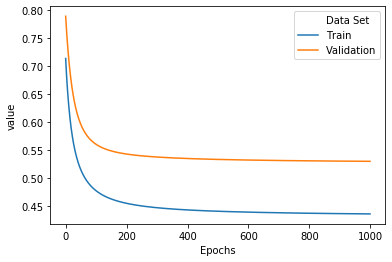

In [25]:
loss_plot = pd.DataFrame(np.transpose([range(epochs), Train_Loss, Val_Loss]), \
                         columns=['Epochs', 'Train', 'Validation']).melt(id_vars='Epochs', var_name='Data Set')
sns.lineplot(x='Epochs', y='value', data=loss_plot, hue='Data Set');

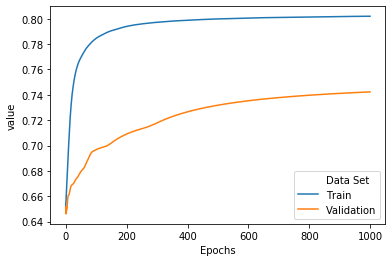

In [26]:
loss_plot = pd.DataFrame(np.transpose([range(epochs), Train_acc, Val_acc]), \
                         columns=['Epochs', 'Train', 'Validation']).melt(id_vars='Epochs', var_name='Data Set')
sns.lineplot(x='Epochs', y='value', data=loss_plot, hue='Data Set');